# Determining the resolution of the Confocal (or STED) microscope from a PSF measurement recorded using a nanodiamond as the point like emitter. 

### Script note:

Import the dependancies for this project. 

In [1]:
import numpy as np 
import scipy.optimize as opt 
import matplotlib.pyplot as plot 
import os
import skimage.feature as si

### Script note:

The data from the .dat file is copied into an numpy array variable.

The metadata is also saved into an array and exported to the main program. 

In [2]:
def get_data(file_location):
    
    # open file and save all data in an array. 
    with open(file_location, 'r') as array3D:
        content = array3D.read()
    
    # intialise variables. 
    image_data = []
    scan_metadata = []
    store_scan_metadata = []
    
    # ignore the first 6 lines of the array (plain text)
    lines = content.splitlines()[6:]
    for line in lines:
        # remove the "new line" text from the row. 
        row = line.split('\t')
        # Save metadata and PSF scan data in separate variables (done by length due to ease)
        # as strings
        if len(row) < 20:
            store_scan_metadata.append(row)
            continue 
        image_data.append(row[0:len(row)-1])
    
    # Extract the metadata for the scan used to create the data_set. 
    scan_metadata = np.array(store_scan_metadata[4]
                             [0:len(store_scan_metadata[4])-1]).astype(float)
    
    # Convert PSF scan data to float. 
    image_data = np.array(image_data).astype(float)
    
    return(image_data, scan_metadata)

### Script note:

Here we generate the scan range for the PSF scan used. 

In [3]:
def generate_3D_scan_range(scan_data):
    
    x_scan = np.linspace(0, scan_data[2]-scan_data[1], int(scan_data[3]))
    y_scan = np.linspace(0, scan_data[5]-scan_data[4], int(scan_data[6]))
    z_scan = np.linspace(0, scan_data[8]-scan_data[7], int(scan_data[9]))
    
    # In python, the 3D stack shape is (z, x, y)
    psf_array_shape = [int(scan_data[9]),  int(scan_data[3]),  int(scan_data[6])]
    
    return([x_scan, y_scan, z_scan], psf_array_shape)

### Script note:

Here we locate the brightest point(s) in the 3D stack.

In [4]:
def find_NDs(image_frame, min_dis, num_NDs):
    # Uses the skimage package to locate the local maxima of an image. 
    nd_locations = si.peak_local_max(image_frame, min_distance = min_dis, exclude_border = True, num_peaks = num_NDs)

    return(nd_locations)

### Script note:

Here we create 3, 2D heatmaps for the XY, XZ and YZ for the PSF of the nanodiamond. 

In [5]:
def plot_xz(scan_range, psf_data, nd_positon):
    
    plot.rcParams.update({'font.size' : 20})
    plot.rcParams.update({'figure.figsize' :[12, 8]})
    
    fig, ax = plot.subplots()
    ax.set_title('PSF XZ scan')
    ax.set_xlabel(r'X scan ($\mu$m)')
    ax.set_ylabel(r'Z scan ($\mu$m)')
    ax = plot.pcolormesh(scan_range[0], scan_range[2], psf_data[:,:, nd_positon[2]])
    fig.colorbar(ax, label = 'Counts per 1.5ms')
    
    
    return(fig, ax)

In [6]:
def plot_yz(scan_range, psf_data, nd_positon):
    
    fig1, ax1 = plot.subplots()
    ax1.set_title('PSF YZ scan')
    ax1.set_xlabel(r'Y scan ($\mu$m)')
    ax1.set_ylabel(r'Z scan ($\mu$m)')
    ax1 = plot.pcolormesh(scan_range[1], scan_range[2], psf_data[:,nd_positon[1], :])
    fig1.colorbar(ax1, label = 'Counts per 1.5ms')

    
    return(fig1, ax1)

In [7]:
def plot_xy(scan_range, psf_data, nd_positon):
    
    fig2, ax2 = plot.subplots()
    ax2.set_title('PSF XZ scan')
    ax2.set_xlabel(r'X scan ($\mu$m)')
    ax2.set_ylabel(r'Y scan ($\mu$m)')
    ax2 = plot.pcolormesh(scan_range[0], scan_range[1], psf_data[nd_positon[0], :, :])
    fig2.colorbar(ax2, label = 'Counts per 1.5ms')
    
    return(fig2, ax2)

In [8]:
def gaussian(x, A, B, C, D):
    # Gaussian curve function. 
    # A = Amplitude, B = Maxima position, C = Standard Diviation
    # D = offset.
    y = A * np.exp(-np.power(x-B, 2)/2*np.power(C,2)) + D
    return (y)

### Script note:

Here we optimise the gaussian fitting for the data set and create the curve fitting for the 1D PSF data. 

In [9]:
def optimise_gaussian(scan_range, psf_1d):
    # Define the intial values for the gaussian fit.
    baseline = np.mean(psf_1d)
    maxima = np.max(psf_1d)
    fwhm = 5
    max_pos = np.where(psf_1d == np.max(psf_1d))
    
    # Pool the intial conditions into one variable. 
    p0 = [maxima-baseline, scan_range[max_pos[0][0]], fwhm, baseline]
    
    # Perform the curve fit using the scipy.optimise toolkit.  
    opt_fit_y, confidence = opt.curve_fit(gaussian, scan_range, psf_1d, p0)
    opt_errors = np.sqrt(np.diag(confidence))
    
    # A higher resolution scan range variable to generate the curve fit. 
    fine_x = np.linspace(0, max(scan_range), 100)
    # Generate the curve fit.
    y_fit = gaussian(fine_x, opt_fit_y[0], opt_fit_y[1], opt_fit_y[2], opt_fit_y[3])
    
    return(opt_fit_y, fine_x, opt_errors, y_fit)

In [10]:
def find_fwhm(y_fit, fine_x, opt_fit_y):
    
    index = []
    
    for i in range(len(y_fit)):
        if y_fit[i] >= opt_fit_y[0]/2 + opt_fit_y[3]:
            index.append(i)
    
    fwhm = fine_x[max(index)] - fine_x[min(index)]
    
    #print(fine_x[max(index)], fine_x[min(index)])        
    #print(fwhm)
    
    return(fwhm)

<ipython-input-5-b7550921e7ec>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax = plot.pcolormesh(scan_range[0], scan_range[2], psf_data[:,:, nd_positon[2]])
<ipython-input-6-7b186d4356f2>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1 = plot.pcolormesh(scan_range[1], scan_range[2], psf_data[:,nd_positon[1], :])


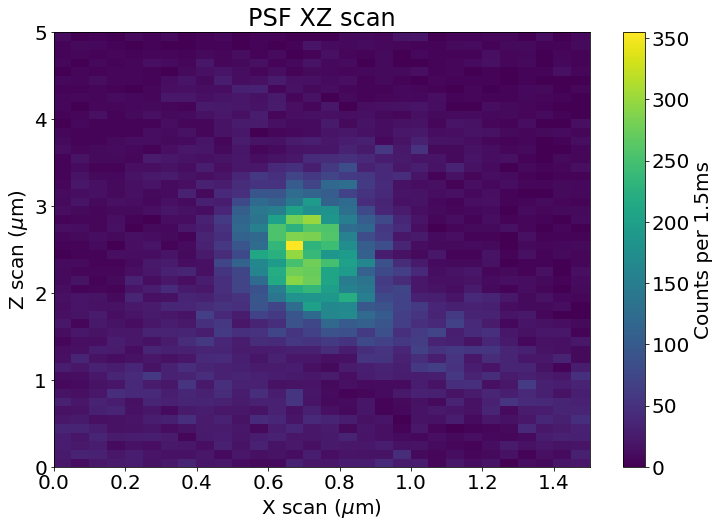

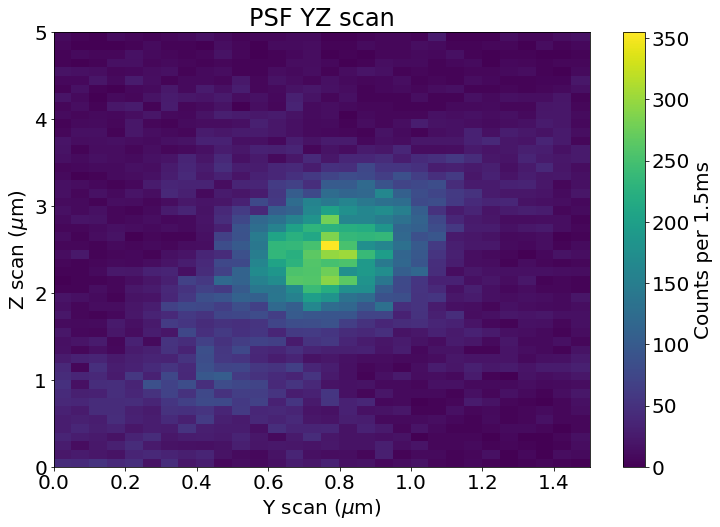

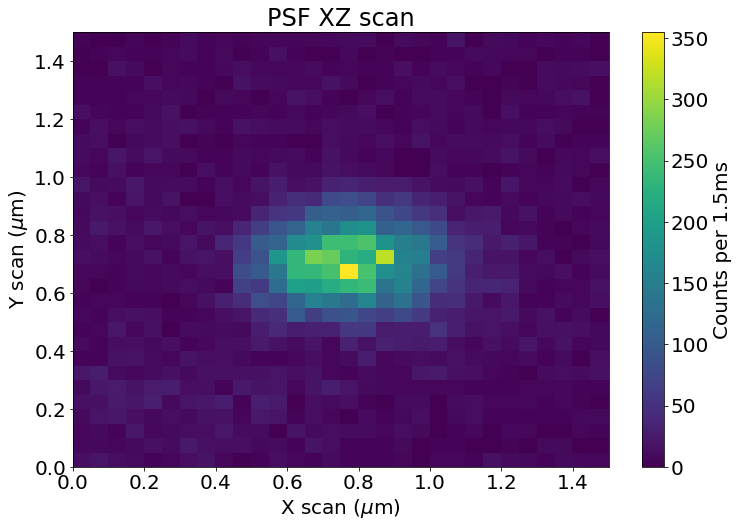

In [27]:
### Get folder location, date and file name. 
folder_location = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\'
date = '20210722'
file_name = date + '_04.dat'

# get PSF data and scan range metadata.
psf_data, scan_metadata = get_data(folder_location + date + '\\' + file_name)

# Take the Meta_data and create an 2D/3D scan array. 
if int(scan_metadata[0]) == 4: 
        scan_range, psf_array_shape = generate_3D_scan_range(scan_metadata)
else: 
    x = 0
    
# reshape PSF array to 3D object. 
psf_data = psf_data.reshape(psf_array_shape[0], psf_array_shape[1],
                 psf_array_shape[2])

# find the PSF in the psf_data (data set, number of pixels away from maxima, number of NDs)
nd_locs = find_NDs(psf_data, 3, 1)

# plot the XY, XZ and YZ data for the PSF. 
fig, ax = plot_xz(scan_range, psf_data, nd_locs[0])
fig1, ax1 = plot_yz(scan_range, psf_data, nd_locs[0])
fig2, ax2 = plot_xy(scan_range, psf_data, nd_locs[0])


[0.25757576 0.36363636 1.11111111]


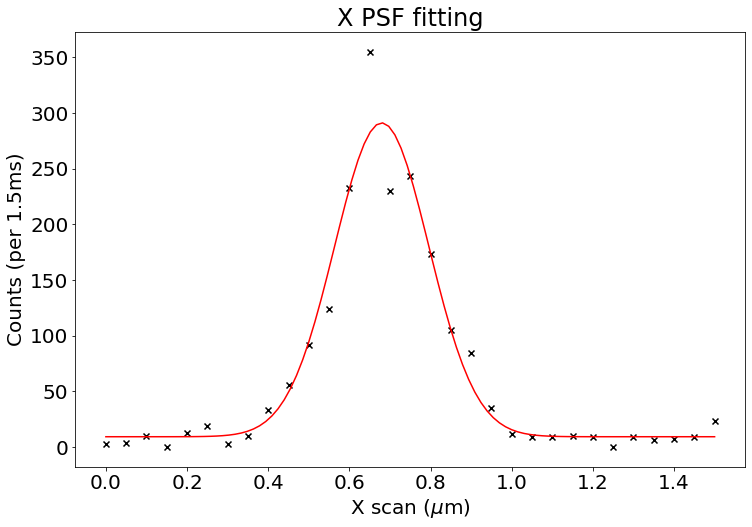

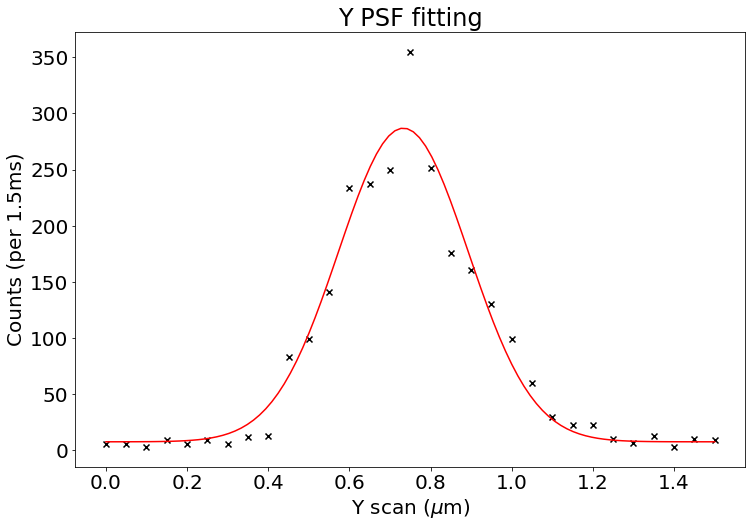

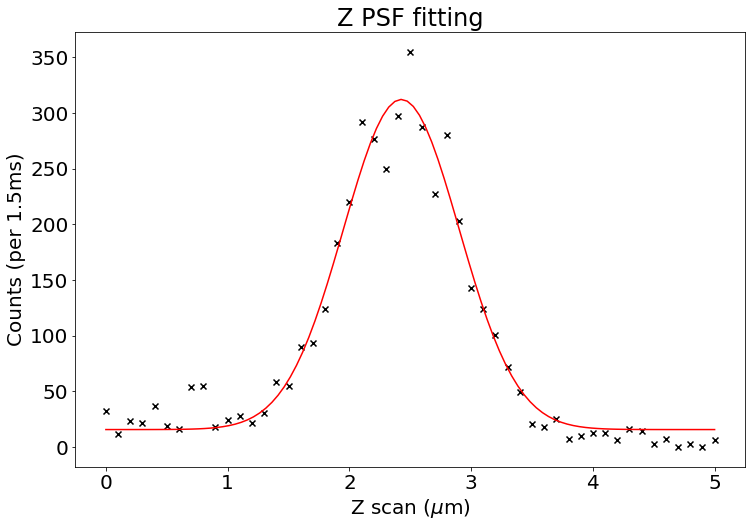

In [28]:
# Create variables for 1D gauss fitting. 
psf_x = psf_data[nd_locs[0][0], :, nd_locs[0][2]]
psf_y = psf_data[nd_locs[0][0], nd_locs[0][1], :]
psf_z = psf_data[:, nd_locs[0][1], nd_locs[0][2]]

fwhm = []

for i in range(3):
    if i == 0:
        fig4, ax4 = plot.subplots()
        ax4.set_title('X PSF fitting')
        ax4.set_xlabel(r'X scan ($\mu$m)')
        ax4.set_ylabel('Counts (per 1.5ms)')
        ax4 = plot.scatter(scan_range[0], psf_x, marker = 'x', color = 'k')
        opt_fit_y, fine_x, opt_errors, y_fit = optimise_gaussian(scan_range[0], psf_x)
        ax4 = plot.plot(fine_x, y_fit, color = 'r')
        
        
    elif i == 1:
        fig5, ax5 = plot.subplots()
        ax5.set_title('Y PSF fitting')
        ax5.set_xlabel(r'Y scan ($\mu$m)')
        ax5.set_ylabel('Counts (per 1.5ms)')
        ax5 = plot.scatter(scan_range[1], psf_y, marker = 'x', color = 'k')
        opt_fit_y, fine_x, opt_errors, y_fit = optimise_gaussian(scan_range[1], psf_y)
        ax5 = plot.plot(fine_x, y_fit, color = 'r')
        
    elif i == 2:
        fig6, ax6 = plot.subplots()
        ax6.set_title('Z PSF fitting')
        ax6.set_xlabel(r'Z scan ($\mu$m)')
        ax6.set_ylabel('Counts (per 1.5ms)')
        ax6 = plot.scatter(scan_range[2], psf_z,  marker = 'x', color = 'k')
        opt_fit_y, fine_x, opt_errors, y_fit = optimise_gaussian(scan_range[2], psf_z)
        ax6 = plot.plot(fine_x, y_fit, color = 'r')
        
    fwhm.append(find_fwhm(y_fit, fine_x, opt_fit_y))

fwhm = np.array(fwhm)
print(fwhm)

### Script note:

I have also included a calculation of the theoretical resolution limit for our confocal microscope. 

lateral resolution = $0.8 \lambda$/2NA 

Axial resolution = $1.4 \lambda$/NA^2

In [19]:
wavelength = (0.532 + 0.700)/2# microns, excitation wavelength.
NA = 1.35

lateral_res = (0.8*wavelength)/(2*NA)
axial_res = (1.4*wavelength)/NA**2

print('lateral resolution = ' + str(np.round(lateral_res, 3)) + r' $\mu$m')
print('axial resolution = ' + str(np.round(axial_res,3))+ r' $\mu$m')

lateral resolution = 0.183 $\mu$m
axial resolution = 0.473 $\mu$m


In [20]:
print(470/3)
print(180/3)

156.66666666666666
60.0
